In [426]:
# This file implements a LTSM model to predict taxi demand for a given zone and time in Porto
# Some portions of this code were generated with ChatGPT (OpenAI, 2023) and are attributed inline where they appear

# References:
# OpenAI. (2023). ChatGPT (Mar 14 version) [Large language model]. https://chat.openai.com/chat

In [486]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import ast
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

In [459]:
# Load dataset
df = pd.read_csv("taxi_trajectories/cleaned_taxi_data.csv") 


In [460]:
# Only sample 600000 rows
df = df.sample(n=600000, random_state=1234)

In [461]:
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,POLYLINE,HOUR,DAY_OF_WEEK,MONTH,TRAJECTORY_LENGTH
1335278,1399476189620000031,0,0.0,20000031,2014-05-07 15:23:09,0,"[[-8.631648, 41.15889], [-8.63181, 41.159079],...",15,NaN,5,49
568182,1383824959620000018,0,0.0,20000018,2013-11-07 11:49:19,0,"[[-8.610075, 41.152941], [-8.609967, 41.152824...",11,NaN,11,45
93529,1374414533620000393,1,15.0,20000393,2013-07-21 13:48:53,0,"[[-8.585586, 41.14845], [-8.585811, 41.148792]...",13,NaN,7,44
1266195,1398243456620000343,1,21.0,20000343,2014-04-23 08:57:36,0,"[[-8.628759, 41.160987], [-8.628678, 41.160942...",8,NaN,4,37
1334937,1399477781620000160,1,15.0,20000160,2014-05-07 15:49:41,0,"[[-8.585667, 41.148477], [-8.585658, 41.148495...",15,NaN,5,63


In [487]:
# This function was generated with help of ChatGPT (OpenAI, 2023) 
def create_zones(df, n_clusters=10):
    # Convert POLYLINE string to list of coordinates and get the first point (pickup location)
    def extract_first_point(polyline_str):
        try:
            coords = ast.literal_eval(polyline_str)  # Convert string to list
            return coords[0] if coords else [np.nan, np.nan]  # Handle empty lists
        except:
            return [np.nan, np.nan]  # Handle invalid formats
    
    # Extract pickup coordinates and keep original index
    pickup_coords = df['POLYLINE'].apply(extract_first_point)
    pickup_df = pd.DataFrame(pickup_coords.tolist(), columns=['pickup_lon', 'pickup_lat'], index=df.index)  # Retain df's original index
    print(pickup_df.head())

    # Remove coordinates outside Porto 
    def remove_non_porto(df):
        return df[(df['pickup_lat'] >= 41.0) & (df['pickup_lat'] <= 41.3) & (df['pickup_lon'] >= -8.7) & (df['pickup_lon'] <= -8.5)]
    
    # Remove rows with invalid or out-of-bound coordinates
    pickup_df = remove_non_porto(pickup_df)

    # Identify valid rows (before dropping NaN)
    valid_indices = pickup_df.dropna().index

    # Remove invalid coordinates (drop NaN values)
    valid_coords = pickup_df.dropna()

    # Ensure there is enough data to perform clustering
    if len(valid_coords) < n_clusters:
        raise ValueError("Not enough valid pickup points for clustering!")

    # Perform K-means clustering on the valid coordinates
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=n_clusters)
    clusters = kmeans.fit(valid_coords)

    # Initialize 'zone' column with -1 (indicating unassigned zone)
    df['zone'] = -1
    df['pickup_coords'] = pickup_coords  # Store the original pickup coordinates in the dataframe

    # Assign cluster labels to the valid indices in the original dataframe
    df.loc[valid_indices, 'zone'] = clusters.labels_

    # Remove rows with zone == -1 (unassigned)
    df = df[df['zone'] != -1]

    df = df.reset_index(drop=True)

    joblib.dump(kmeans, "taxi_trajectories/zone.pkl")

    return df, kmeans

In [463]:
# This function was generated with help of ChatGPT (OpenAI, 2023) 
def group_data_by_zone_and_datetime(df):
    # Group by datetime hour and zone to get demand count
    hourly_zone_demand = df.groupby([
        pd.Grouper(key='TIMESTAMP', freq='H'),
        'zone'
    ]).size().reset_index()
    hourly_zone_demand.columns = ['TIMESTAMP', 'zone', 'demand']
    
    # Pivot table to get demand for each zone in columns
    demand_matrix = hourly_zone_demand.pivot(
        index='TIMESTAMP',
        columns='zone',
        values='demand'
    ).fillna(0)

    # Ensure the index is sorted for time series consistency
    demand_matrix = demand_matrix.sort_index()
    
    return demand_matrix

In [464]:
# this function generated via chat gpt
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:(i + seq_length)])
        targets.append(data[i + seq_length])
    
    return np.array(sequences), np.array(targets)

In [465]:
def build_lstm_model(seq_length, n_zones, num_lags):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(256, input_shape=(seq_length, n_zones * (num_lags + 1) + 1), return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(n_zones, activation='relu')
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [488]:
n_clusters=5
seq_length=24
test_size=0.2
epochs=50


# Create zones
df_with_zones, kmeans = create_zones(df, n_clusters)
    

         pickup_lon  pickup_lat
1335278   -8.631648   41.158890
568182    -8.610075   41.152941
93529     -8.585586   41.148450
1266195   -8.628759   41.160987
1334937   -8.585667   41.148477


In [467]:
# Group data by zone and datetime
df_with_zones['TIMESTAMP'] = pd.to_datetime(df_with_zones['TIMESTAMP'])
demand_matrix = group_data_by_zone_and_datetime(df_with_zones)
# Extract day of week and hour
demand_matrix['day_of_week'] = demand_matrix.index.dayofweek  # Monday=0, Sunday=6
demand_matrix['hour'] = demand_matrix.index.hour

# Create the bar_traffic flag (1 for Fri & Sat 2AM-4AM, else 0)
demand_matrix['bar_traffic'] = ((demand_matrix['day_of_week'].isin([4, 5])) &  # Friday (4) & Saturday (5)
                                (demand_matrix['hour'].between(2, 4))).astype(int)

# drop day of week and hour
demand_matrix = demand_matrix.drop(['day_of_week', 'hour'], axis=1)

print(demand_matrix.shape)
print(demand_matrix.head())

/var/folders/mv/1l8hsgqn1gg1ysw_5rvfsz7c0000gp/T/ipykernel_31373/2417362806.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.Grouper(key='TIMESTAMP', freq='H'),


(8760, 6)
zone                    0    1    2    3    4  bar_traffic
TIMESTAMP                                                 
2013-07-01 00:00:00  19.0  2.0  3.0  2.0  8.0            0
2013-07-01 01:00:00  15.0  1.0  2.0  0.0  1.0            0
2013-07-01 02:00:00  13.0  2.0  2.0  2.0  5.0            0
2013-07-01 03:00:00  15.0  4.0  1.0  5.0  5.0            0
2013-07-01 04:00:00  13.0  3.0  2.0  5.0  6.0            0


   zone  pickup_lat  pickup_lon
0     0   -8.611212   41.148175
1     1   -8.667951   41.163851
2     2   -8.583358   41.154858
3     3   -8.599291   41.177272
4     4   -8.635240   41.160782


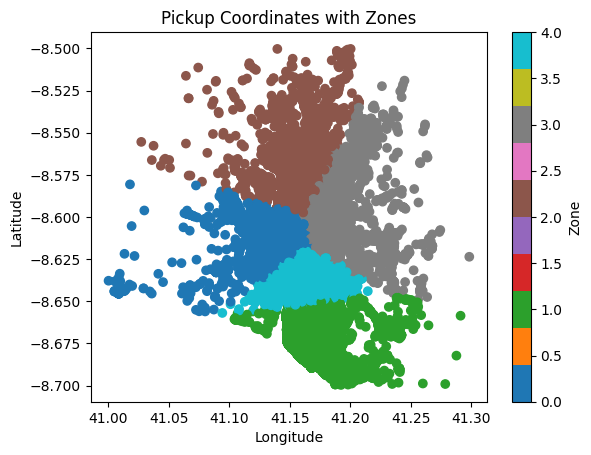

In [474]:
# Group by 'zone' to see the coordinates for each zone
df_with_zones[['pickup_lat', 'pickup_lon']] = pd.DataFrame(df_with_zones['pickup_coords'].tolist(), index=df_with_zones.index)
df_with_zones.head()

zone_coords = df_with_zones.groupby('zone').agg({'pickup_lat': 'mean', 'pickup_lon': 'mean'}).reset_index()

print(zone_coords)

import matplotlib.pyplot as plt

plt.scatter(df_with_zones['pickup_lon'], df_with_zones['pickup_lat'], c=df_with_zones['zone'], cmap='tab10')
plt.title("Pickup Coordinates with Zones")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Zone")
plt.show()

In [ ]:
# this function generated via chat gpt
def add_lag_features(df, lags=[1, 2, 3]):
    """
    Adds lag features for demand prediction.
    
    Parameters:
    df (pd.DataFrame): Dataframe with 'TIMESTAMP' as index and demand columns per zone.
    lags (list): List of lag values (e.g., [1, 2, 3] for 1-hour, 2-hour, 3-hour lag)
    
    Returns:
    pd.DataFrame: DataFrame with additional lagged demand columns.
    """
    df_lagged = df.copy()
    
    for lag in lags:
        df_lagged[[f'lag_{lag}_zone_{col}' for col in df.columns]] = df.shift(lag)
    
    return df_lagged.dropna()  # Drop NaNs caused by shifting

demand_matrix_with_lag = add_lag_features(demand_matrix, lags=[1, 2, 3])  # Add 1-hour, 2-hour, 3-hour lags

# remove the lag columns
demand_matrix_with_lag = demand_matrix_with_lag.drop(['lag_1_zone_bar_traffic', 'lag_2_zone_bar_traffic', 'lag_3_zone_bar_traffic'], axis=1)

demand_matrix_with_lag.columns = demand_matrix_with_lag.columns.astype(str)
scaler = MinMaxScaler()
scaled_demand_with_lag = scaler.fit_transform(demand_matrix_with_lag)
    
# Create sequences
X, y = create_sequences(scaled_demand_with_lag, seq_length)
# for y select only the zone columns and not the lag columns
y = y[:, :n_clusters]
print(X.shape, y.shape)

(8733, 24, 21) (8733, 5)


In [472]:
    
    # Split data
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(6986, 24, 21) (6986, 5) (1747, 24, 21) (1747, 5)


In [473]:


# Build and train model
model = build_lstm_model(seq_length, n_clusters, num_lags=3)
    
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=32,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)
    

/Users/bosky/boskymsaiicoursework/src/module2-assginment/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - loss: 0.0135 - mae: 0.0812 - val_loss: 0.0068 - val_mae: 0.0545
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.0066 - mae: 0.0565 - val_loss: 0.0053 - val_mae: 0.0494
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.0055 - mae: 0.0523 - val_loss: 0.0047 - val_mae: 0.0485
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0049 - mae: 0.0497 - val_loss: 0.0044 - val_mae: 0.0476
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0047 - mae: 0.0485 - val_loss: 0.0045 - val_mae: 0.0465
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - loss: 0.0044 - mae: 0.0466 - val_loss: 0.0040 - val_mae: 0.0442
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0042 - mae: 0.0462 - val_loss: 0.0040 - val_mae: 0.0432
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0042 - mae: 0.0454 - val_loss: 0.0043 - val_mae: 0.0451
Epoch 9/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


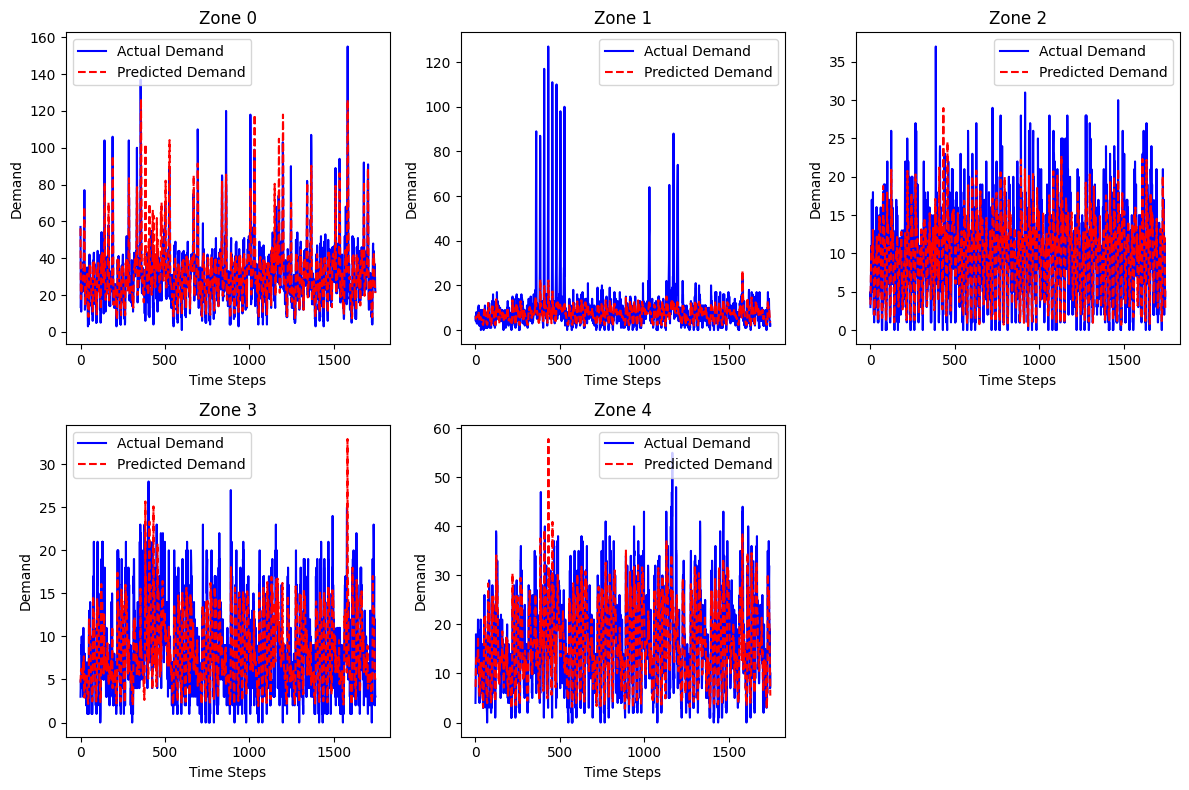

In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)


y_test_actual = scaler.inverse_transform(np.pad(y_test, ((0,0), (0,16)), 'constant')[:, :21])
y_pred_actual = scaler.inverse_transform(np.pad(y_pred, ((0,0), (0,16)), 'constant')[:, :21])

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  
axes[1, 2].axis("off") 

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot actual vs predicted for all zones
for zone_index in range(n_clusters):
    axes[zone_index].plot(y_test_actual[:, zone_index], label='Actual Demand', color='blue')
    axes[zone_index].plot(y_pred_actual[:, zone_index], label='Predicted Demand', color='red', linestyle='--')
    axes[zone_index].set_title(f'Zone {zone_index}')
    axes[zone_index].set_xlabel('Time Steps')
    axes[zone_index].set_ylabel('Demand')
    axes[zone_index].legend()

# Adjust the layout
plt.tight_layout()
plt.show()

In [482]:

mae_per_zone = [mean_absolute_error(y_test_actual[:, i], y_pred_actual[:, i]) for i in range(n_clusters)]
print("MAE per zone:", mae_per_zone)
mse_per_zone = [mean_squared_error(y_test_actual[:, i], y_pred_actual[:, i]) for i in range(n_clusters)]
print("MSE per zone:", mse_per_zone)
rmse_per_zone = [np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_actual[:, i])) for i in range(n_clusters)]
print("RMSE per zone:", rmse_per_zone)

# Prepare the data for better formatting
rmse_per_zone_rounded = [round(rmse, 3) for rmse in rmse_per_zone]

# Create a DataFrame to display the results neatly
metrics_df = pd.DataFrame({
    'Zone': [f'Zone {i}' for i in range(n_clusters)],
    'RMSE': rmse_per_zone_rounded
})

# Display the RMSE values in a clean format
print(metrics_df)

MAE per zone: [6.789593798403202, 4.082710533191221, 3.018270578497672, 2.605545858621734, 4.00079266043752]
MSE per zone: [111.9049831372064, 113.75649628136368, 16.211676110137446, 13.197536908490223, 32.05830930367074]
RMSE per zone: [np.float64(10.578515166941266), np.float64(10.665669049870415), np.float64(4.0263725746802725), np.float64(3.6328414372898554), np.float64(5.6620057668348185)]
     Zone    RMSE
0  Zone 0  10.579
1  Zone 1  10.666
2  Zone 2   4.026
3  Zone 3   3.633
4  Zone 4   5.662


In [456]:
print(y_test_actual.shape)
timestamps = demand_matrix_with_lag.index[-len(y_test_actual):] 

print(y_pred_actual.shape)
print(y_pred)

# Creating DataFrame for actual values
# only pick the first 5 zones
y_test_actual_5 = y_test_actual[:, :5]
y_pred_actual_5 = y_pred_actual[:, :5]
df_results = pd.DataFrame(y_test_actual_5, columns=[f"Actual_Zone_{i+1}" for i in range(y_test_actual_5.shape[1])])

# Adding predictions
for i in range(y_pred_actual_5.shape[1]):
    df_results[f"Predicted_Zone_{i+1}"] = y_pred_actual_5[:, i]

# Add timestamps
df_results.insert(0, "Timestamp", timestamps)


df_results.to_csv("taxi_trajectories/zone_actual_predictions.csv", index=False)

(1747, 21)
(1747, 21)
[[0.40378228 0.05314483 0.05638193 0.12258359 0.12407696]
 [0.23559597 0.04544944 0.0895144  0.13859324 0.13810828]
 [0.12749091 0.04362952 0.12110829 0.15433481 0.15913202]
 ...
 [0.1429161  0.03914907 0.12226051 0.14483537 0.14898752]
 [0.13502797 0.03550249 0.09484126 0.12799461 0.12048885]
 [0.11680861 0.03121824 0.0662733  0.12851214 0.0995415 ]]
